In [11]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt

In [12]:
# table_data = pd.read_csv("/data1/yejb/prosit/figure3/supply_origin/fine-tuned.csv")
table_data = pd.read_csv(
    "/data1/yejb/prosit/figure3/supply_origin/aligned-fine-tuned-IAA-noIAA-0.01.csv")


In [13]:
# table_data[table_data['SM_v2'].apply(lambda x: bool(x))]['SM_v2']
# table_data[table_data['Sequence'].apply(lambda x: len(x) == 7)]


In [14]:
# def read_allele_len_me(data, allele, length):
#     alleles = data[data['Allele'] == allele]
#     alleles = alleles[alleles['Sequence'].apply(lambda x: len(x) == length)]
#     baseline = alleles[alleles['SM_v2'].apply(
#         lambda x: bool(x))]['Sequence'].to_list()
#     prosit = alleles[alleles['Prosit'].apply(
#         lambda x: bool(x))]['Sequence'].to_list()
#     finetuned = alleles[alleles['Prosit(original)'].apply(
#         lambda x: bool(x))]['Sequence'].to_list()
#     return baseline, prosit, finetuned


# all_alleles = table_data['Allele'].unique()
# all_length = [8, 9, 10, 11]
# for allele in all_alleles:
#     for length in all_length:
#         _, prosit, finetuned = read_allele_len_me(
#             table_data, allele, length)
#         prosit = set(prosit)
#         finetuned = set(finetuned)
#         print(len(prosit), len(finetuned), len(prosit.intersection(finetuned)))


In [15]:

def read_allele_len(data, allele, length):
    alleles = data[data['Allele'] == allele]
    alleles = alleles[alleles['Sequence'].apply(lambda x: len(x) == length)]
    baseline = alleles[alleles['SM_v2'].apply(
        lambda x: bool(x))]['Sequence'].to_list()
    prosit = alleles[alleles['Prosit(original)'].apply(
        lambda x: bool(x))]['Sequence'].to_list()
    finetuned = alleles[alleles['Fine-tuned Prosit'].apply(
        lambda x: bool(x))]['Sequence'].to_list()
    return baseline, prosit, finetuned

def LSG(p1, p2):
    p1 = set(p1)
    p2 = set(p2)
    return p1-p2, p1.intersection(p2), p2-p1

In [16]:
def all_unique_char(data):
    all_peptides = data["Sequence"]
    all_peptides = "".join(all_peptides)
    return set(all_peptides)

def extract_pos(peps, pos):
    return [ [p[i] for i in pos]for p in peps]

class Labeler:
    def __init__(self, unique_char):
        self._reverse = list(unique_char)
        self._dict = {
            c : i
            for i, c in enumerate(self._reverse)
        }
    def encode(self, peptide):
        return [self._dict[c] for c in peptide]

    def decode(self, pep_index):
        return "".join([self._reverse[i] for i in pep_index])
    
    def encode_batch(self, peptides):
        return [self.encode(p) for p in peptides]
    
    def decode_batch(self, pep_indexs):
        return [self.decode(p) for p in pep_indexs]
    
    def position_matrix(self, pep_indexs, length):
        mat = np.zeros((length, len(self._reverse)))    
        for p in pep_indexs:
            for i in range(length):
                mat[i, p[i]] += 1
        return mat
    
    def emission_mat(self, pep_indexs, length):
        mat = self.position_matrix(pep_indexs, length)
        return mat/(mat.sum(1).reshape(-1, 1) + 1e-9)
    
    def get_top_pos(self, pep_indexs, length, topk=5):
        mat = self.position_matrix(pep_indexs, length)
        pos_rank = np.max(mat, axis=1)
        return np.argsort(pos_rank)[::-1][:topk]

In [17]:
all_alleles = table_data['Allele'].unique()
all_length = [8, 9, 10, 11]

topk_pos = 5
labeller = Labeler(all_unique_char(table_data))


In [18]:
def emission_prob(em_mat, pep_index):
    assert len(em_mat) == len(pep_index)
    prob = 0
    for i in range(len(em_mat)):
        prob += np.log10(1e-7 + em_mat[i, pep_index[i]])
    return prob

from tqdm import tqdm

prosit_dict = defaultdict(list)
finetuned_dict = defaultdict(list)

all_length = [8, 9, 10, 11]
for allele in tqdm(all_alleles):
    ems_prosit = defaultdict(list)
    ems_finetuned = defaultdict(list)
    for length in all_length:
        baseline, prosit, finetuned = read_allele_len(
            table_data, allele, length)
        if len(baseline) == 0:
            continue
        # prosit
        baseline_i = labeller.encode_batch(set(baseline))
        needed_pos = labeller.get_top_pos(baseline_i, length, topk=topk_pos)

        inter = extract_pos(baseline_i, needed_pos)
        em_mat = labeller.emission_mat(inter, topk_pos)
        loss, shared, gain = LSG(baseline, prosit)
        for name, pep in zip(['Loss', 'Shared', "Gain"], [loss, shared, gain]):
            pep_i = labeller.encode_batch(pep)
            if len(pep_i) == 0:
                continue
            pep_i = np.array(extract_pos(pep_i, needed_pos))
            for p in pep_i:
                s = emission_prob(em_mat, p)
                ems_prosit[name].append(s)
        # finetuned
        baseline_i = labeller.encode_batch(set(baseline))
        needed_pos = labeller.get_top_pos(baseline_i, length, topk=topk_pos)
        inter = extract_pos(baseline_i, needed_pos)
        em_mat = labeller.emission_mat(inter, topk_pos)
        
        loss, shared, gain = LSG(baseline, finetuned)
        for name, pep in zip(['Loss', 'Shared', "Gain"], [loss, shared, gain]):
            pep_i = labeller.encode_batch(pep)
            if len(pep_i) == 0:
                continue
            pep_i = np.array(extract_pos(pep_i, needed_pos))
            for p in pep_i:
                s = emission_prob(em_mat, p)
                ems_finetuned[name].append(s)
    if len(ems_prosit) == 0 or len(ems_finetuned) == 0:
        print(f"Wrong shot at {allele}")
    for name in ['Loss', 'Shared', "Gain"]:
        prosit_dict[name].append(np.mean(ems_prosit[name]))
        finetuned_dict[name].append(np.mean(ems_finetuned[name]))


100%|██████████| 89/89 [00:15<00:00,  5.72it/s]


In [19]:
for k, v in prosit_dict.items():
    print(k, f"({len(v)}) Medium: {np.median(v):.3f}", f"Std: {np.std(v):.3f}")

Loss (89) Medium: -4.861 Std: 0.437
Shared (89) Medium: -4.284 Std: 0.312
Gain (89) Medium: -4.790 Std: 0.335


In [20]:
for k, v in finetuned_dict.items():
    print(k, f"({len(v)}) Mean: {np.median(v):.3f}", f"Std: {np.std(v):.3f}")


Loss (89) Mean: -4.645 Std: 0.389
Shared (89) Mean: -4.200 Std: 0.326
Gain (89) Mean: -5.222 Std: 0.650


(-6.1, -3.0)

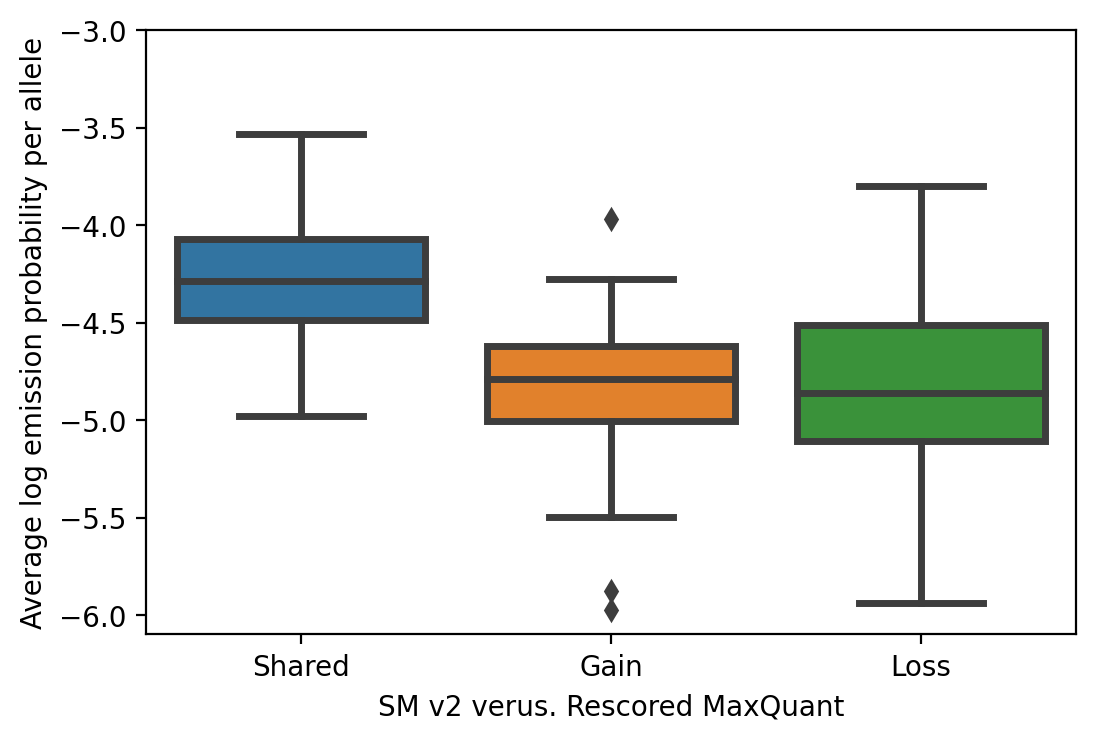

In [25]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 200
plot_dict = {}
plot_dict["Average log emission probability per allele"] = prosit_dict['Shared'] + prosit_dict['Gain'] + prosit_dict['Loss']
plot_dict["SM v2 verus. Rescored MaxQuant"] = ['Shared']*len(prosit_dict['Shared']) + ['Gain']*len(prosit_dict['Gain']) + ['Loss']*len(prosit_dict['Loss'])
df = pd.DataFrame(plot_dict)
ax = sns.boxplot(data=df, x='SM v2 verus. Rescored MaxQuant',
            y='Average log emission probability per allele', linewidth=2.5)
ax.set_ylim(-6.1, -3)


In [22]:
def plot_error(method_dict):
    c_loss = 'orange'
    c_shared = 'darkslateblue'
    c_gain = 'darkgreen'
    fig, ax = plt.subplots(figsize=(9, 6), dpi=100)
    
    x = [1, 2, 3]
    em_mean = [np.mean(method_dict[p]) for p in ['Shared', "Gain", "Loss"]]
    em_std = [np.std(method_dict[p]) for p in ['Shared', "Gain", "Loss"]]
    ax.scatter(x, em_mean)
    ax.errorbar(x, em_mean, yerr=em_std, fmt='o')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    
    plt.show()

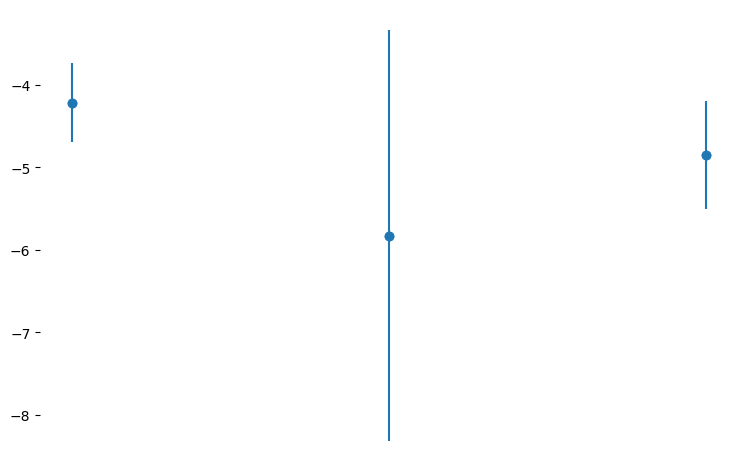

In [30]:
plot_error(prosit_dict)